In [1]:
import torch
import torchvision
import torch.nn.functional as F
import albumentations
import albumentations.pytorch
import pytorchtrainutils as ptu
from efficientnet_pytorch import EfficientNet

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import argparse

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

#parser = argparse.ArgumentParser()
#parser.add_argument('--arch', type=str, help='resnet18-34-50-101, desnenet121-*, -efficientnet-b*')
#args = parser.parse_args()

In [2]:
basepath = '/home/ubuntu/data/chexpert'
arch = 'densenet121'
name = f'{arch}-224'

seed = 42
device = torch.device('cuda')
ptu.utils.set_seed(seed)

# Dataset loading

In [3]:
# Data loading & preprocessing
def preprocess_df(df):
    #df = df[df['Frontal/Lateral'] == 'Frontal'].copy()
    df['No Finding'].fillna(0, inplace=True)
    df = df.replace(-1, 0.5)
    return df.copy()

def get_class_weights(df):
    classes = df.iloc[:, 5:].values.T
    class_weights = []

    for class_idx in range(classes.shape[0]):
        samples = classes[class_idx]
        
        samples = samples[np.where(~np.isnan(samples))]
        samples = samples[np.where(~(samples == 0.5))]

        pos_weight = len(samples) / ((samples == 1).sum() + 1e-4)
        neg_weight = len(samples) / ((samples == 0).sum() + 1e-4)
        
        weights = [neg_weight, pos_weight]
        class_weights.append(weights)

    class_weights = torch.tensor(class_weights)
    class_weights = torch.cat((class_weights, torch.ones(class_weights.shape[0], 1, dtype=class_weights.dtype)), 1)
    return class_weights

In [4]:
train_df = pd.read_csv(os.path.join(basepath, 'CheXpert-v1.0-small', 'train.csv'))
val_df = pd.read_csv(os.path.join(basepath, 'CheXpert-v1.0-small', 'valid.csv'))
train_df = preprocess_df(train_df)
val_df = preprocess_df(val_df)
val_df.iloc[-1, 17] = 1 # Add a fake fracture=0, or roc won't work

train_weight = get_class_weights(train_df).to(device)
val_weight = get_class_weights(val_df).to(device)
#train_weight, val_weight = None, None

# Dataloaders & transforms
class CheXpert(torch.utils.data.dataset.Dataset):
    def __init__(self, df, path, transform):
        super().__init__()

        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        entry = self.df.iloc[index]
        fname = entry.Path
        fname = os.path.join(self.path, fname)

        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)[:, :, np.newaxis]
        img = self.transform(image=img)['image']
        
        labels = entry.values[5:].astype('float')
        return img, labels

# Mean & std

In [5]:
img_size = EfficientNet.get_image_size(name) if 'efficient' in name else 224
print(f'{name} image size: {img_size}')

stats_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size, always_apply=True),
    albumentations.pytorch.ToTensor()
])

stats_dataset = CheXpert(train_df, basepath, transform=stats_transforms)
stats_loader = torch.utils.data.DataLoader(stats_dataset, batch_size=64, num_workers=8, shuffle=True)
#mean, std = ptu.utils.get_mean_and_std(stats_loader, device=device)
mean, std = [0.5024], [0.2898]
print(f'Mean & std for CheXpert: {mean}, {std}')

densenet121-224 image size: 224
Mean & std for CheXpert: [0.5024], [0.2898]


# Transforms

In [6]:
def get_transforms(img_size, crop_size):
    train_transforms = albumentations.Compose([
        albumentations.Resize(img_size, img_size, always_apply=True),
        albumentations.HorizontalFlip(p=0.3),
        albumentations.ShiftScaleRotate(rotate_limit=10, shift_limit=0.1, scale_limit=1.5),
        albumentations.Normalize(mean, std),
        albumentations.pytorch.ToTensor()
    ])

    transforms = albumentations.Compose([
        albumentations.Resize(img_size, img_size, always_apply=True),
        albumentations.Normalize(mean, std),
        albumentations.pytorch.ToTensor()
    ])
    
    return train_transforms, transforms

def get_dataloaders(train_transforms, transforms, batch_size):
    train_dataset = CheXpert(train_df, basepath, transform=train_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    val_dataset = CheXpert(val_df, basepath, transform=transforms)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    
    return train_loader, val_loader

# Loss function

In [7]:
# Loss 
def sparse_bce(preds, targets, weight=None):
    # Do not use sigmoid in model, this is stabler
    loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
    
    if weight is not None:
        targets_clone = targets.clone()
        targets_clone[torch.where(torch.isnan(targets_clone))] = 2 # do not weigh nan (w=1).
        targets_clone[torch.where(targets_clone == 0.5)] = 2       # do not weigh 0.5 (w=1).

        weight = weight[:, targets_clone.T.long()]
        idx = np.diag_indices(weight.shape[0])
        weight = weight[idx[0], idx[1], :]
        loss *= weight.T 
    
    # prevent nan propagation in backward
    nan_idx = torch.where(torch.isnan(loss.flatten()))
    with torch.no_grad():
        targets.flatten().data[nan_idx] = 0.
        loss.flatten().data[nan_idx] = 0.

    
    return loss.mean()

# Patched metrics

In [8]:
# metrics fix
class MultilabelAccuracyPatch(ptu.metrics.MultilabelAccuracy):
    def get_class_preds(self, class_idx):
        outputs = self.sigmoid(self.outputs)
        targets = self.targets

        class_outputs = outputs[:, class_idx]
        class_targets = targets[:, class_idx]
        
        idx = torch.where(~(class_targets == 0.5))
        class_outputs = class_outputs[idx]
        class_targets = class_targets[idx]

        idx = torch.where(~torch.isnan(class_targets))
        class_outputs = class_outputs[idx]
        class_targets = class_targets[idx]

        return class_outputs, class_targets

class MultilabelRocAucPatch(ptu.metrics.MultilabelRocAuc):
    def get_class_preds(self, class_idx):
        outputs = self.sigmoid(self.outputs)
        targets = self.targets

        class_outputs = outputs[:, class_idx]
        class_targets = targets[:, class_idx]
        
        idx = torch.where(~(class_targets == 0.5))
        class_outputs = class_outputs[idx]
        class_targets = class_targets[idx]

        idx = torch.where(~torch.isnan(class_targets))
        class_outputs = class_outputs[idx]
        class_targets = class_targets[idx]

        return class_outputs, class_targets

# Utilities

In [9]:
classes = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices'
]

def plot_roc_auc_all(name, aucs, accs, path, show=False):
    plt.figure(figsize=(20, 20))
    plt.suptitle(f'{name} Classification report - average AUC: {aucs.get():.4f}')
    for class_idx, class_name in enumerate(classes):
        plt.subplot(4, 4, class_idx+1)
        plt.title(f'{class_name} BA={accs.class_ba(class_idx):.4f}')
        fpr, tpr, _ = aucs.class_curve(class_idx)
        plt.plot(fpr, tpr, label=f'AUC: {aucs.class_auc(class_idx):.4f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
        plt.legend(loc='lower right')
    plt.savefig(path)
    if show:
        plt.show()
    plt.clf()

def plot_roc_auc_selected(name, aucs, accs, path, show=False):
    # baseline model auc: 0.850       0.900             0.900      0.920       0.97
    # best model on LB:   0.909       0.910             0.957      0.958       0.964
    # baseli densenet121: 0.810       0.787             0.896      0.912       0.922 
    # baseline resnet18:  0.812       0.797             0.875      0.903       0.913
    val_classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

    idx = [classes.index(x) for x in val_classes]
    sub_aucs = []

    plt.figure(figsize=(20, 10))
    for i, (class_idx, class_name) in enumerate(zip(idx, val_classes)):
        plt.subplot(2, 3, i+1)
        plt.title(f'{class_name} BA={accs.class_ba(class_idx):.4f}')
        fpr, tpr, _ = aucs.class_curve(class_idx)
        auc = aucs.class_auc(class_idx)
        sub_aucs.append(auc)
        plt.plot(fpr, tpr, label=f'AUC: {auc:.4f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
        plt.legend(loc='lower right')
    plt.suptitle(f'{name} Classification report - selected classes - average AUC: {np.mean(sub_aucs):.4f}')
    plt.savefig(path)
    if show:
        plt.show()
    plt.clf()

def plot_roc_auc(name, aucs, accs):
    plot_roc_auc_all(name=name, aucs=aucs, accs=accs, path=f'{name}/auc-all.png')
    plot_roc_auc_selected(name=name, aucs=aucs, accs=accs, path=f'{name}/auc-val.png')

# Model

In [10]:
# Model creation
"""
No Finding                   TOP   0    
Enlarged Cardiomediastinum   TOP   1    
Cardiomegaly                       2    
Lung Opacity                 TOP   3    
Lung Lesion                        4    
Edema                              5    
Consolidation                      6    
Pneumonia                          7    
Atelectasis                        8    
Pneumothorax                 TOP   9    
Pleural Effusion             TOP   10   
Pleural Other                TOP   11   
Fracture                     TOP   12   
Support Devices              TOP   13
"""

class HierarchicalResidual(torch.nn.Module):
    def __init__(self, encoder='resnet18', pretrained=True):
        super().__init__()

        self.encoder_name = encoder
        self.encoder = None
        self.num_ft = 0

        if 'resnet' in encoder:
            resnets = {
                'resnet18': torchvision.models.resnet18,
                'resnet34': torchvision.models.resnet34,
                'resnet50': torchvision.models.resnet50,
                'resnet101': torchvision.models.resnet101,
            }

            self.encoder = resnets[encoder](pretrained=pretrained)
            self.encoder.conv1.weight.data = self.encoder.conv1.weight.data[:, :1]
            self.encoder.conv1.in_channels = 1
            self.num_ft = self.encoder.fc.in_features
            self.encoder = torch.nn.Sequential(*list(self.encoder.children())[:-1])
        
        elif 'densenet' in encoder:
            self.encoder = torch.hub.load('pytorch/vision:v0.6.0', encoder, pretrained=pretrained)
            self.encoder.features.conv0.weight.data = self.encoder.features.conv0.weight.data[:, :1]
            self.encoder.features.conv0.in_channels = 1
            self.num_ft = self.encoder.classifier.in_features
            self.encoder = torch.nn.Sequential(
                self.encoder.features,
                torch.nn.ReLU(inplace=True),
                torch.nn.AdaptiveAvgPool2d((1, 1))
            )

        elif 'efficientnet' in encoder:
            self.encoder._conv_stem.weight.data = self.encoder._conv_stem.weight.data[:, :1]
            self.encoder._conv_stem.in_channels = 1
            self.encoder = EfficientNet.from_pretrained(encoder)
            self.num_ft = self.encoder._fc.in_features
           
        else:
            print(f'Unkown encoder {encoder}')
            exit(1)

        """parent classes [
            No Finding, Enlarged Cardiomediastinum, Lung Opacity, 
            Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support devices
        ]
        """
        self.fc1 = torch.nn.Linear(in_features=self.num_ft, out_features=8, bias=True)

        """child classes [
            Cardiomegaly, Lung Lesion, Edema, Consolidation, Pneumonia, Atelactasis
        ]
        """
        self.fc2 = torch.nn.Linear(in_features=self.num_ft+8, out_features=6, bias=True)
        
        # Sort output with correct label order
        output_order = torch.tensor([2, 4, 5, 6, 7, 8, 0, 1, 3, 9, 10, 11, 12, 13])
        self.out_idx = torch.argsort(output_order)
    
    def forward(self, x):
        if 'efficientnet' in self.encoder_name:
            x = self.encoder.extract_features(x)
            x = self.encoder._avg_pooling(x)
            
        else:
            x = self.encoder(x)

        x = torch.flatten(x, 1)

        parent = self.fc1(x)
        x = torch.cat((x, parent), dim=1)
        x = F.relu(x)
        x = self.fc2(x)

        x = torch.cat((x, parent), dim=1)
        return x[:, self.out_idx]

In [11]:
# Init
model = HierarchicalResidual(encoder=arch, pretrained=True).to(device)

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


# Training on 224

In [12]:
train_transforms, transforms = get_transforms(img_size=250, crop_size=224)
train_loader, val_loader = get_dataloaders(train_transforms, transforms, batch_size=64)

In [13]:
# Optimizer
criterion = sparse_bce
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)
lr_scheduler = lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [14]:
tracked_metrics = [
    MultilabelAccuracyPatch(metric='avg-ba'),
    MultilabelRocAucPatch()
]

best_model = ptu.trainer.fit(
    model, train_dataloader=train_loader, val_dataloader=val_loader,
    test_dataloader=None, test_every=0, criterion=criterion,
    optimizer=optimizer, scheduler=lr_scheduler, metrics=tracked_metrics, n_epochs=10,
    metric_choice='loss', mode='min', weight={'train': train_weight, 'val': val_weight},
    name=name, device=device,
    callbacks={'val': lambda: plot_roc_auc(name=name, aucs=tracked_metrics[1], accs=tracked_metrics[0]) }
)

Epoch: 000 | VAL avg-ba: 0.5840 - col-auc: 0.7108 - loss: 1.9590 | TRAIN 

avg-ba: 0.5635 - col-auc: 0.6750 - loss: 0.4406 |


Epoch: 001 | VAL avg-ba: 0.5963 - col-auc: 0.7294 - loss: 1.9564 | TRAIN 

avg-ba: 0.5879 - col-auc: 0.7022 - loss: 0.4144 |


Epoch: 002 | VAL avg-ba: 0.5876 - col-auc: 0.7476 - loss: 1.9198 | TRAIN 

avg-ba: 0.5971 - col-auc: 0.7182 - loss: 0.4050 |


Epoch: 003 | VAL avg-ba: 0.5989 - col-auc: 0.7531 - loss: 1.9062 | TRAIN 

avg-ba: 0.6024 - col-auc: 0.7227 - loss: 0.3994 |


Epoch: 005 | VAL avg-ba: 0.6008 - col-auc: 0.7732 - loss: 1.8489 | TRAIN 

avg-ba: 0.6089 - col-auc: 0.7359 - loss: 0.3918 |


Epoch: 006 | VAL avg-ba: 0.6089 - col-auc: 0.7710 - loss: 1.8377 | TRAIN 

avg-ba: 0.6114 - col-auc: 0.7366 - loss: 0.3889 |


Epoch: 007 | VAL avg-ba: 0.5992 - col-auc: 0.7678 - loss: 1.9116 | TRAIN 

avg-ba: 0.6135 - col-auc: 0.7402 - loss: 0.3867 |


# Training on 448

In [15]:
name = f'{arch}-448'

In [16]:
train_transforms, transforms = get_transforms(img_size=500, crop_size=448)
train_loader, val_loader = get_dataloaders(train_transforms, transforms, batch_size=16)

In [17]:
# Optimizer
criterion = sparse_bce
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)
lr_scheduler = lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [18]:
tracked_metrics = [
    MultilabelAccuracyPatch(metric='avg-ba'),
    MultilabelRocAucPatch()
]

# Train
best_model = ptu.trainer.fit(
    model, train_dataloader=train_loader, val_dataloader=val_loader,
    test_dataloader=None, test_every=0, criterion=criterion,
    optimizer=optimizer, scheduler=lr_scheduler, metrics=tracked_metrics, n_epochs=10,
    metric_choice='loss', mode='min', weight={'train': train_weight, 'val': val_weight},
    name=name, device=device,
    callbacks={'val': lambda: plot_roc_auc(name=name, aucs=tracked_metrics[1], accs=tracked_metrics[0]) }
)

Epoch: 002 | VAL avg-ba: 0.6325 - col-auc: 0.7830 - loss: 1.8962 | TRAIN 

avg-ba: 0.6144 - col-auc: 0.7441 - loss: 0.3876 |


Epoch: 003 | VAL avg-ba: 0.6349 - col-auc: 0.7853 - loss: 1.9025 | TRAIN 

avg-ba: 0.6175 - col-auc: 0.7476 - loss: 0.3838 |


Epoch: 004 | VAL avg-ba: 0.6317 - col-auc: 0.7726 - loss: 1.8836 | TRAIN 

avg-ba: 0.6198 - col-auc: 0.7522 - loss: 0.3808 |


Epoch: 006 | VAL avg-ba: 0.6347 - col-auc: 0.7926 - loss: 1.8690 | TRAIN 

avg-ba: 0.6237 - col-auc: 0.7592 - loss: 0.3760 |


Epoch: 008 | VAL avg-ba: 0.6359 - col-auc: 0.7717 - loss: 2.0030 | TRAIN 

avg-ba: 0.6271 - col-auc: 0.7643 - loss: 0.3713 |


Epoch: 009 | VAL avg-ba: 0.6374 - col-auc: 0.7656 - loss: 1.9047 | TRAIN 

avg-ba: 0.6281 - col-auc: 0.7660 - loss: 0.3701 |


Training finished


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

# Test

In [19]:
val_logs = ptu.trainer.test(
    model=best_model, test_dataloader=val_loader, 
    criterion=criterion, metrics=tracked_metrics, 
    weight=val_weight, device=device
)

TEST | avg-ba: 0.6347 - col-auc: 0.7926 - loss: 1.8690


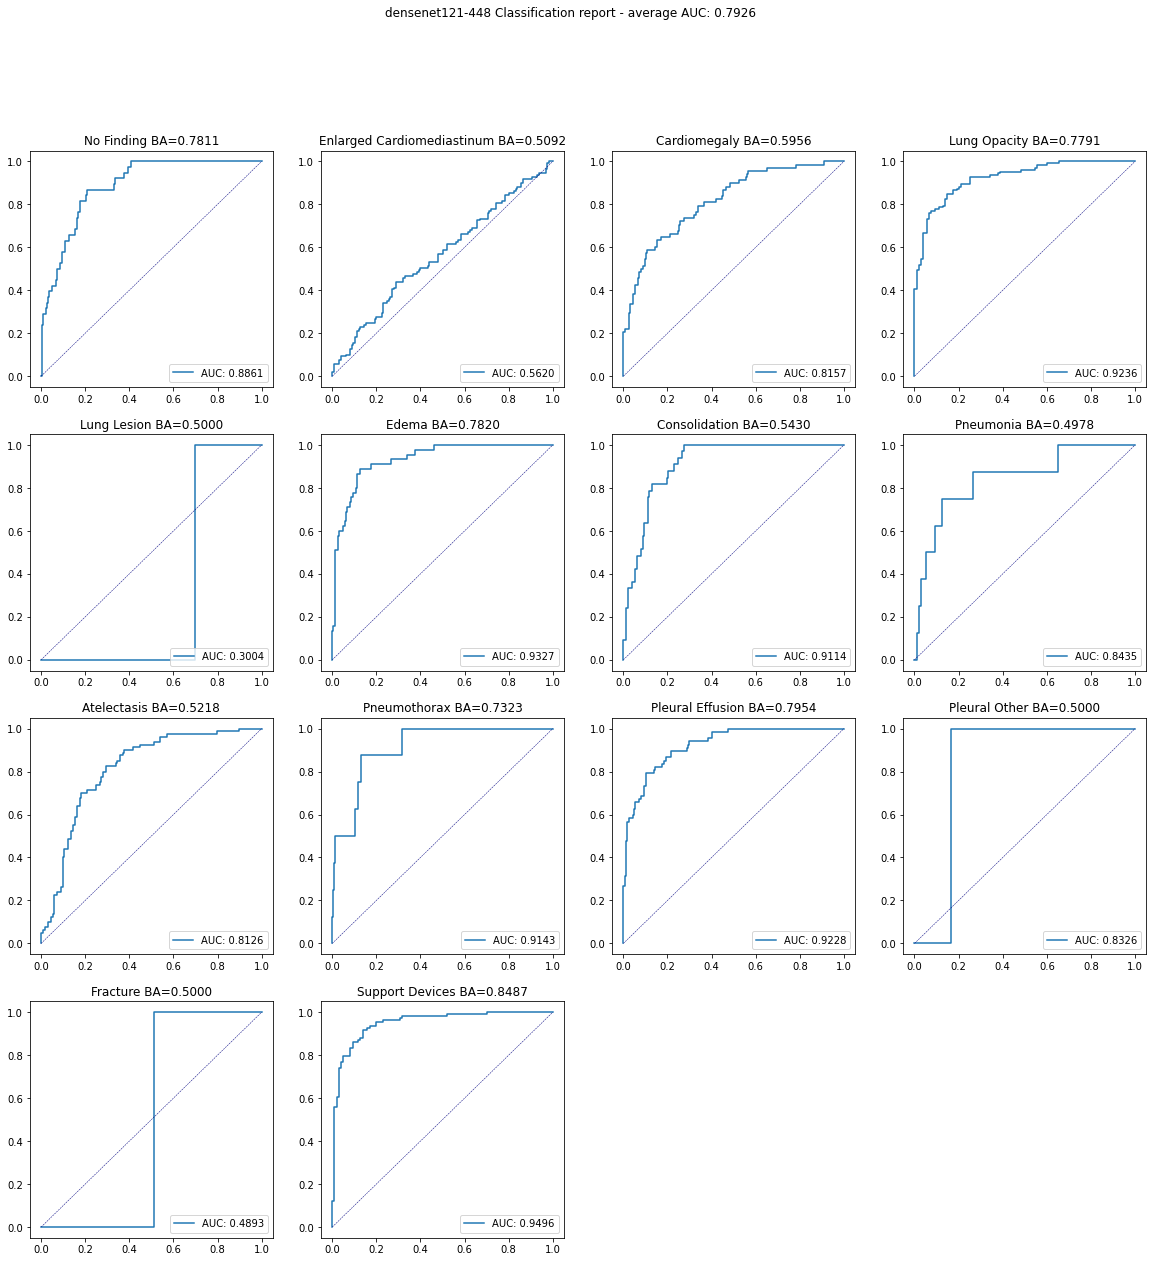

<Figure size 432x288 with 0 Axes>

In [20]:
plot_roc_auc_all(name, aucs=val_logs['col-auc'], accs=val_logs['avg-ba'], path=f'{name}/auc-all-best.png', show=True)

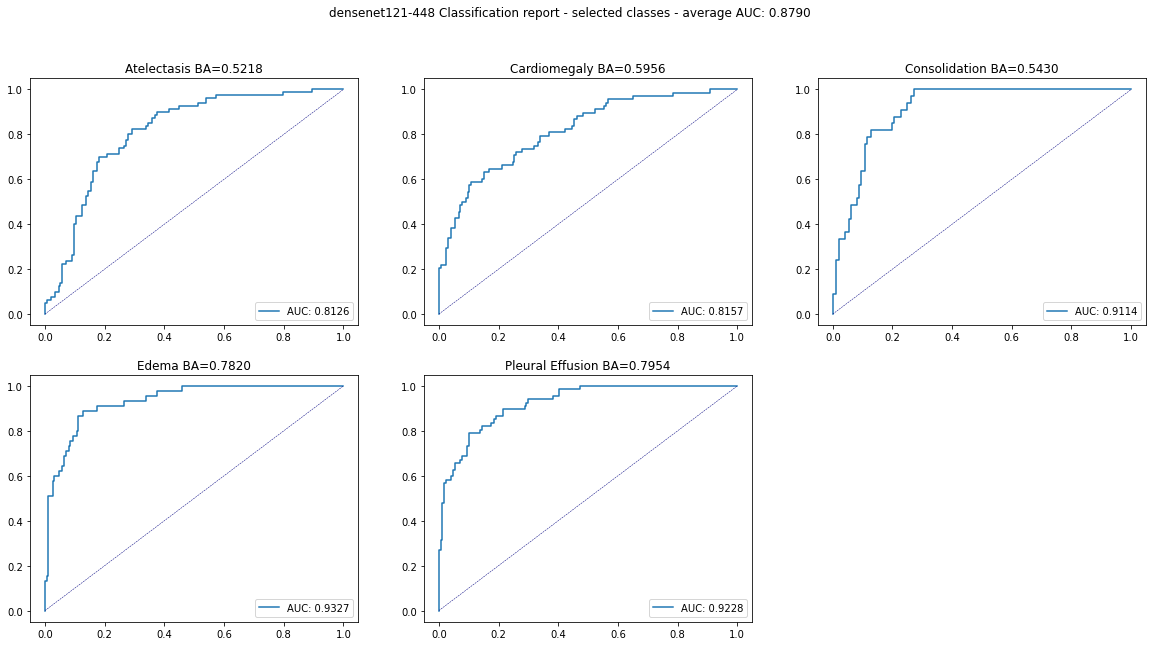

<Figure size 432x288 with 0 Axes>

In [21]:
plot_roc_auc_selected(name, aucs=val_logs['col-auc'], accs=val_logs['avg-ba'], path=f'{name}/auc-val-best.png', show=True)